In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import math

from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.inspection import permutation_importance
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, balanced_accuracy_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn import preprocessing

from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler

import io

In [4]:
#import file of training ==> imbalanced dataset

metrics_results = {}

training_df = pd.read_csv("Training.csv", decimal=r',', sep=';')
size_of_training = len(training_df.index)

classlabel_count = training_df.classlabel.value_counts()
print('Class 0:', classlabel_count[0])
print('Class 1:', classlabel_count[1])
print('Proportion:', round(classlabel_count[0] / classlabel_count[1], 2), ': 1')
training_df.info()

Class 0: 3424
Class 1: 276
Proportion: 12.41 : 1
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3700 entries, 0 to 3699
Data columns (total 22 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   v33         3634 non-null   object 
 1   v76         3700 non-null   object 
 2   v12         3661 non-null   float64
 3   v68         3700 non-null   object 
 4   v50         3700 non-null   float64
 5   v7          3661 non-null   object 
 6   v70         3700 non-null   object 
 7   v55         3600 non-null   float64
 8   v20         3700 non-null   float64
 9   v24         3700 non-null   int64  
 10  v32         3636 non-null   object 
 11  v97         3700 non-null   float64
 12  v28         3700 non-null   object 
 13  v99         3634 non-null   object 
 14  v95         1555 non-null   object 
 15  v42         3600 non-null   float64
 16  v53         3700 non-null   int64  
 17  v85         3636 non-null   object 
 18  v9          3700 no

In [3]:
#import file of training

validation_df = pd.read_csv("Validation.csv", decimal=r',', sep=';')
validation_df_goal = validation_df[["classlabel"]]
size_of_validation = len(validation_df.index)

validation_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 22 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   v33         197 non-null    object 
 1   v76         200 non-null    object 
 2   v12         197 non-null    float64
 3   v68         200 non-null    object 
 4   v50         200 non-null    float64
 5   v7          197 non-null    object 
 6   v70         200 non-null    object 
 7   v55         197 non-null    float64
 8   v20         200 non-null    float64
 9   v24         200 non-null    int64  
 10  v32         198 non-null    object 
 11  v97         200 non-null    float64
 12  v28         200 non-null    object 
 13  v99         197 non-null    object 
 14  v95         89 non-null     object 
 15  v42         197 non-null    float64
 16  v53         200 non-null    int64  
 17  v85         198 non-null    object 
 18  v9          200 non-null    int64  
 19  v84         200 non-null    o

In [4]:
#prepare goal variable to boolean

training_df["classlabel"] = np.where(training_df['classlabel'] == "yes.", 1,0)
validation_df["classlabel"] = np.where(validation_df['classlabel'] == "yes.", 1,0)


In [5]:
def get_index_nparray(nparray, value):
    index, = np.where(nparray == value)
    if(index.size > 0):
        return np.int(index)
    return -1

def preprocessing_dataframe(df):
    
    classes_of_columns = {}
    for colname, coltype in df.dtypes.iteritems():
        if(coltype == np.dtype(object)):
            le = preprocessing.LabelEncoder()
            df[colname] = df[colname].astype(str)
            le.fit(df[colname])
            classes_of_columns[colname] = le.classes_
            df[colname] = le.transform(df[colname])
    
    return df, classes_of_columns

def preprocessing_transform_dataframe(df, classes_of_columns):
    for key in classes_of_columns:
        df[key] = df[key].apply(lambda row: get_index_nparray(classes_of_columns[key], row))
    return df

def remove_remaining_null_values(df):
    check_null_values_remaining = df.isnull().sum()

    for index, value in check_null_values_remaining.items():
        df[index].fillna(-1, inplace=True)
    
    return df

In [6]:
training_df, classes_of_columns = preprocessing_dataframe(training_df)

validation_df = preprocessing_transform_dataframe(validation_df, classes_of_columns)


In [7]:
training_df = remove_remaining_null_values(training_df)
validation_df = remove_remaining_null_values(validation_df)


In [8]:
# Observando a correlação percebemos uma alta relação entre a classe e a feature v68
# determinando que existe uma colinearidade quase perfeita (0.98)
# Devido a isto pode haver um grande problema em utilizá-la no modelo

# Em seguida aparecem as features v70, v84, v24, v44, v95, v55 respectivamente
# Porém, v95 possuía uma alta quantidade de valores nulos antes dos tratamentos
# Com isso não levarei em considereção v95, pois pode se tratar de um vazamento

# Sem o balanceamento da base de treinamento a performance de quase todos algoritmos
# cai bastante

training_df_goal = training_df[["classlabel"]]
training_df_without_goal = training_df.drop('classlabel', axis=1)
rus = RandomUnderSampler()
X_training, y_training = rus.fit_resample(training_df_without_goal, training_df_goal)

concat_resampled_training_df = pd.concat([X_training, y_training], axis=1)
concat_resampled_training_df.corr().sort_values("classlabel", ascending=False).head(10)


,v33,v76,v12,v68,v50,v7,v70,v55,v20,v24,...,v28,v99,v95,v42,v53,v85,v9,v84,v44,classlabel
classlabel,-0.082616,-0.097996,0.158072,0.985533,0.330435,-0.084870,0.416603,-0.091270,0.202105,0.410951,...,0.072956,0.091711,0.319588,-0.091269,0.200741,-0.209382,-0.054391,0.440456,0.370150,1.000000
v68,-0.082203,-0.100178,0.157989,1.000000,0.325924,-0.094712,0.410258,-0.088462,0.200129,0.407185,...,0.081099,0.092765,0.319944,-0.088462,0.198950,-0.204496,-0.054682,0.436142,0.365612,0.985533
v84,-0.008969,-0.087369,0.102019,0.436142,0.213452,-0.039128,0.240448,-0.100726,0.170137,0.181044,...,0.040663,0.007496,0.149644,-0.100774,0.025651,-0.101156,-0.621162,1.000000,-0.374629,0.440456
v70,-0.067752,-0.195606,0.112122,0.410258,0.267244,-0.063891,1.000000,-0.110746,0.234835,0.594203,...,0.028794,0.033052,0.681355,-0.110803,0.150724,-0.187749,-0.056927,0.240448,0.204313,0.416603
v24,-0.132541,-0.118192,0.278376,0.407185,0.473950,-0.049653,0.594203,-0.132571,0.381636,1.000000,...,0.041572,0.036510,0.440681,-0.132624,0.141697,-0.062945,0.019805,0.181044,0.258412,0.410951
v44,-0.092614,-0.053676,0.143442,0.365612,0.180017,-0.066927,0.204313,0.037648,0.143975,0.258412,...,0.081366,0.067907,0.177958,0.037587,0.174284,-0.112896,0.603110,-0.374629,1.000000,0.370150
v50,-0.138897,-0.048764,0.413069,0.325924,1.000000,0.115651,0.267244,-0.125201,0.334686,0.473950,...,0.168223,0.006244,0.274716,-0.125276,0.126429,-0.066508,-0.014665,0.213452,0.180017,0.330435
v95,-0.032888,-0.159453,0.115383,0.319944,0.274716,0.013110,0.681355,-0.023302,0.124752,0.440681,...,0.026580,0.029816,1.000000,-0.023351,0.160800,-0.183036,-0.024741,0.149644,0.177958,0.319588
v20,-0.094066,-0.169479,0.244845,0.200129,0.334686,-0.016768,0.234835,-0.294289,1.000000,0.381636,...,0.019656,-0.081681,0.124752,-0.294315,0.061435,-0.068364,-0.010432,0.170137,0.143975,0.202105
v53,-0.146228,-0.073223,0.109469,0.198950,0.126429,-0.091188,0.150724,0.042510,0.061435,0.141697,...,-0.057612,0.008894,0.160800,0.042571,1.000000,-0.064518,0.066560,0.025651,0.174284,0.200741


In [9]:
# Observando a correlação nos dados de validação, a feature v68 nem chega perto de ter uma boa correlação
# Logo, como vimos antes utilizar esta feature no modelo realmente resultaria em 
# análises ruins

# As feature v70, v84, v24, v44, v50 aparecem com uma taxa de correlação semelhante

validation_df.corr().sort_values("classlabel", ascending=False).head(10)

,v33,v76,v12,v68,v50,v7,v70,v55,v20,v24,...,v28,v99,v95,v42,v53,v85,v9,v84,v44,classlabel
classlabel,0.010672,-0.133062,0.269343,-0.010025,0.328898,0.077743,0.569050,-0.105037,0.203549,0.477300,...,-0.090221,0.165673,0.107560,-0.105111,0.303216,-0.149818,-0.032577,0.371493,0.415512,1.000000
v70,0.087184,-0.281271,0.194099,-0.040032,0.218419,-0.045393,1.000000,-0.007214,0.189978,0.688892,...,-0.080064,0.147322,0.351948,-0.007284,0.301005,-0.120118,-0.025777,0.239467,0.329782,0.569050
v24,0.078061,-0.213530,0.220900,0.036705,0.245805,-0.025677,0.688892,-0.099897,0.290847,1.000000,...,-0.121954,0.086917,0.182196,-0.099951,0.252296,-0.134160,-0.107796,0.297431,0.196383,0.477300
v44,-0.137578,-0.108139,0.136865,-0.086488,0.285209,-0.017075,0.329782,-0.042227,0.102207,0.196383,...,0.043244,0.004675,0.102107,-0.042226,0.143386,-0.099396,0.600191,-0.402472,1.000000,0.415512
v84,0.085713,-0.001372,0.084034,0.056647,0.082460,0.032805,0.239467,-0.042460,0.115236,0.297431,...,-0.033988,0.104564,0.104033,-0.042506,0.086122,0.005012,-0.670573,1.000000,-0.402472,0.371493
v50,-0.042817,-0.024730,0.280210,0.024474,1.000000,0.097809,0.218419,-0.041487,0.375161,0.245805,...,0.056661,0.062556,0.175086,-0.041434,0.144022,-0.107304,0.060247,0.082460,0.285209,0.328898
v53,0.018035,-0.135586,0.116704,-0.026033,0.144022,0.071923,0.301005,-0.009881,0.054199,0.252296,...,-0.110470,0.025723,-0.012750,-0.009912,1.000000,-0.082236,0.005013,0.086122,0.143386,0.303216
v12,-0.128732,-0.091111,1.000000,-0.055476,0.280210,0.093702,0.194099,-0.116090,0.246742,0.220900,...,-0.052203,0.082477,0.017903,-0.116107,0.116704,-0.054529,0.016452,0.084034,0.136865,0.269343
v20,0.097964,-0.069266,0.246742,0.161384,0.375161,-0.108480,0.189978,-0.271116,1.000000,0.290847,...,-0.084994,0.078060,0.079808,-0.271182,0.054199,-0.105077,-0.036448,0.115236,0.102207,0.203549
v99,-0.221859,-0.110926,0.082477,0.036035,0.062556,-0.109267,0.147322,-0.008328,0.078060,0.086917,...,0.020270,1.000000,0.176967,-0.008405,0.025723,-0.094697,-0.035666,0.104564,0.004675,0.165673


Acurácia - 0.82
Acurácia balanceada - 0.8233343382574616
F1 Score - 0.8181818181818182


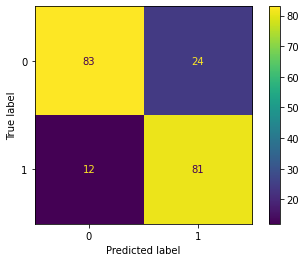

In [10]:
# O modelo realizando de ávore usando a seleção de features observando os critérios anteriores
# Com a inclusão da feature v53, a performance é um pouco melhor que com as 5 features acima
# de 0.30 de correlação

seed = 10
tree = DecisionTreeClassifier(criterion='gini',
    min_samples_leaf=15,
    min_samples_split=5,
    max_depth=None,
    random_state=seed)

df_train_corr = concat_resampled_training_df[["v84", "v24", "v50", "v44", "v53"]]
df_train_classlabel = concat_resampled_training_df[["classlabel"]]
tree.fit(df_train_corr, df_train_classlabel)

real_classlabel_validation = validation_df[["classlabel"]]
data_validation_without_classlabel = validation_df[["v84", "v24", "v50", "v44", "v53"]]

predicted_classlabel = tree.predict(data_validation_without_classlabel)
accuracy = accuracy_score(real_classlabel_validation, predicted_classlabel)
balanced_accuracy = balanced_accuracy_score(real_classlabel_validation, predicted_classlabel)
f1_score_metric = f1_score(real_classlabel_validation, predicted_classlabel)
confusion_matrix_metric = confusion_matrix(real_classlabel_validation, predicted_classlabel)

metrics_results["decision_tree_six_features"] = {"accuracy": accuracy, \
    "balanced_accuracy": balanced_accuracy, "f1_score_metric": f1_score_metric}

print( "Acurácia - " + str(accuracy))
print( "Acurácia balanceada - " + str(balanced_accuracy))
print( "F1 Score - " + str(f1_score_metric))
ConfusionMatrixDisplay(confusion_matrix=confusion_matrix_metric).plot()


Acurácia - 0.495
Acurácia balanceada - 0.4949753793588584
F1 Score - 0.4766839378238342


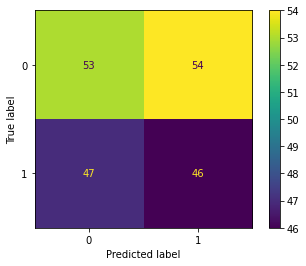

In [11]:
# Modelo de árvore usando todas as features
# A feature v68 está influenciando muito o modelo, gerando um resultado bem abaixo

seed = 10
tree = DecisionTreeClassifier(criterion='gini',
    min_samples_leaf=15,
    min_samples_split=5,
    max_depth=None,
    random_state=seed)

df_train_classlabel = concat_resampled_training_df[["classlabel"]]
df_train_corr = concat_resampled_training_df.drop('classlabel', axis=1)

tree.fit(df_train_corr, df_train_classlabel)

real_classlabel_validation = validation_df[["classlabel"]]
data_validation_without_classlabel = validation_df.drop('classlabel', axis=1)

predicted_classlabel = tree.predict(data_validation_without_classlabel)
accuracy = accuracy_score(real_classlabel_validation, predicted_classlabel)
balanced_accuracy = balanced_accuracy_score(real_classlabel_validation, predicted_classlabel)
f1_score_metric = f1_score(real_classlabel_validation, predicted_classlabel)
confusion_matrix_metric = confusion_matrix(real_classlabel_validation, predicted_classlabel)

metrics_results["decision_tree_all_features"] = {"accuracy": accuracy, \
    "balanced_accuracy": balanced_accuracy, "f1_score_metric": f1_score_metric}

print( "Acurácia - " + str(accuracy))
print( "Acurácia balanceada - " + str(balanced_accuracy))
print( "F1 Score - " + str(f1_score_metric))
ConfusionMatrixDisplay(confusion_matrix=confusion_matrix_metric).plot()

Acurácia - 0.8
Acurácia balanceada - 0.8074565370314541
F1 Score - 0.8095238095238095


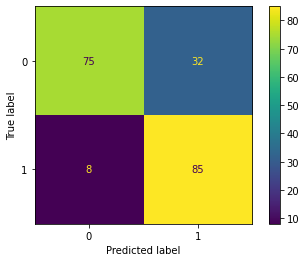

In [12]:
# Modelo de árvore usando todas as features, com exceção da v68
# De fato, como levantado de hipótese anteriormente, a feature v68 influencia 
# bastante de forma negativa o modelo. Apesar da melhora, o resultado utilizando a
# seleção de features ainda tem performance melhor

seed = 10
tree = DecisionTreeClassifier(criterion='gini',
    min_samples_leaf=15,
    min_samples_split=5,
    max_depth=None,
    random_state=seed)

df_train_classlabel = concat_resampled_training_df[["classlabel"]]
df_train_corr = concat_resampled_training_df.drop(columns=['classlabel', 'v68'])

tree.fit(df_train_corr, df_train_classlabel)

real_classlabel_validation = validation_df[["classlabel"]]
data_validation_without_classlabel = validation_df.drop(columns=['classlabel', 'v68'])

predicted_classlabel = tree.predict(data_validation_without_classlabel)

accuracy = accuracy_score(real_classlabel_validation, predicted_classlabel)
balanced_accuracy = balanced_accuracy_score(real_classlabel_validation, predicted_classlabel)
f1_score_metric = f1_score(real_classlabel_validation, predicted_classlabel)
confusion_matrix_metric = confusion_matrix(real_classlabel_validation, predicted_classlabel)

metrics_results["decision_tree_except_v68"] = {"accuracy": accuracy, \
    "balanced_accuracy": balanced_accuracy, "f1_score_metric": f1_score_metric}

print( "Acurácia - " + str(accuracy))
print( "Acurácia balanceada - " + str(balanced_accuracy))
print( "F1 Score - " + str(f1_score_metric))
ConfusionMatrixDisplay(confusion_matrix=confusion_matrix_metric).plot()

Acurácia - 0.62
Acurácia balanceada - 0.593508190131645
F1 Score - 0.3448275862068966


/Users/atila/.pyenv/versions/3.7.9/lib/python3.7/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


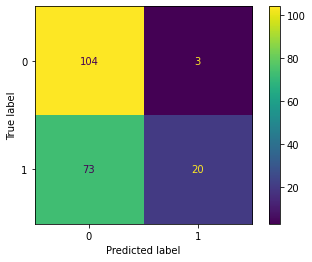

In [13]:
# Utilizando o modelo de naive bayes extraindo as features prejudiciais, existe uma grande
# quantidade de falsos negativos

df_train_classlabel = concat_resampled_training_df[["classlabel"]]
df_train_corr = concat_resampled_training_df.drop(columns=['classlabel', 'v68', 'v95'])

real_classlabel_validation = validation_df[["classlabel"]]
data_validation_without_classlabel = validation_df.drop(columns=['classlabel', 'v68', 'v95'])

gnb = GaussianNB()
predicted_classlabel = gnb.fit(df_train_corr, df_train_classlabel).predict(data_validation_without_classlabel)

accuracy = accuracy_score(real_classlabel_validation, predicted_classlabel)
balanced_accuracy = balanced_accuracy_score(real_classlabel_validation, predicted_classlabel)
f1_score_metric = f1_score(real_classlabel_validation, predicted_classlabel)
confusion_matrix_metric = confusion_matrix(real_classlabel_validation, predicted_classlabel)

metrics_results["naive_bayes_except_v68_v95"] = {"accuracy": accuracy, \
    "balanced_accuracy": balanced_accuracy, "f1_score_metric": f1_score_metric}

print( "Acurácia - " + str(accuracy))
print( "Acurácia balanceada - " + str(balanced_accuracy))
print( "F1 Score - " + str(f1_score_metric))
ConfusionMatrixDisplay(confusion_matrix=confusion_matrix_metric).plot()

Acurácia - 0.85
Acurácia balanceada - 0.8534820621043111
F1 Score - 0.8484848484848486


/Users/atila/.pyenv/versions/3.7.9/lib/python3.7/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


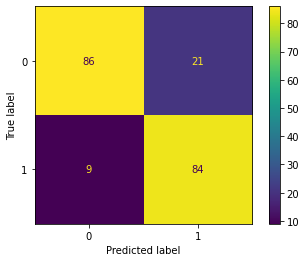

In [14]:
# Utilizando o modelo de Naive Bayes agora selecionando as features escolhidas a performance sobe
# superando a árvore de decisão em todas as métricas e reduzindo falsos positivos

df_train_classlabel = concat_resampled_training_df[["classlabel"]]
df_train_corr = concat_resampled_training_df[["v70", "v84", "v24", "v44", "v50"]]

real_classlabel_validation = validation_df[["classlabel"]]
data_validation_without_classlabel = validation_df[["v70", "v84", "v24", "v44", "v50"]]

gnb = GaussianNB()
predicted_classlabel = gnb.fit(df_train_corr, df_train_classlabel).predict(data_validation_without_classlabel)

accuracy = accuracy_score(real_classlabel_validation, predicted_classlabel)
balanced_accuracy = balanced_accuracy_score(real_classlabel_validation, predicted_classlabel)
f1_score_metric = f1_score(real_classlabel_validation, predicted_classlabel)
confusion_matrix_metric = confusion_matrix(real_classlabel_validation, predicted_classlabel)

metrics_results["naive_bayes_five_features"] = {"accuracy": accuracy, \
    "balanced_accuracy": balanced_accuracy, "f1_score_metric": f1_score_metric}

print( "Acurácia - " + str(accuracy))
print( "Acurácia balanceada - " + str(balanced_accuracy))
print( "F1 Score - " + str(f1_score_metric))
ConfusionMatrixDisplay(confusion_matrix=confusion_matrix_metric).plot()

Acurácia - 0.795
Acurácia balanceada - 0.7880112551502362
F1 Score - 0.757396449704142


/Users/atila/.pyenv/versions/3.7.9/lib/python3.7/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


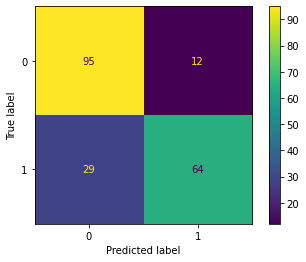

In [15]:
# Adicionando a feature v53 ao Naive Bayes, a performance cai, trazendo a conclusão que as features com 
# correlação acima de 0.30 são as ideais

df_train_classlabel = concat_resampled_training_df[["classlabel"]]
df_train_corr = concat_resampled_training_df[["v70", "v84", "v24", "v44", "v50", "v53"]]

real_classlabel_validation = validation_df[["classlabel"]]
data_validation_without_classlabel = validation_df[["v70", "v84", "v24", "v44", "v50", "v53"]]

gnb = GaussianNB()
predicted_classlabel = gnb.fit(df_train_corr, df_train_classlabel).predict(data_validation_without_classlabel)

accuracy = accuracy_score(real_classlabel_validation, predicted_classlabel)
balanced_accuracy = balanced_accuracy_score(real_classlabel_validation, predicted_classlabel)
f1_score_metric = f1_score(real_classlabel_validation, predicted_classlabel)
confusion_matrix_metric = confusion_matrix(real_classlabel_validation, predicted_classlabel)

metrics_results["naive_bayes_six_features"] = {"accuracy": accuracy, \
    "balanced_accuracy": balanced_accuracy, "f1_score_metric": f1_score_metric}

print( "Acurácia - " + str(accuracy))
print( "Acurácia balanceada - " + str(balanced_accuracy))
print( "F1 Score - " + str(f1_score_metric))
ConfusionMatrixDisplay(confusion_matrix=confusion_matrix_metric).plot()

Acurácia - 0.85
Acurácia balanceada - 0.8569992965531102
F1 Score - 0.8557692307692307


/Users/atila/.pyenv/versions/3.7.9/lib/python3.7/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


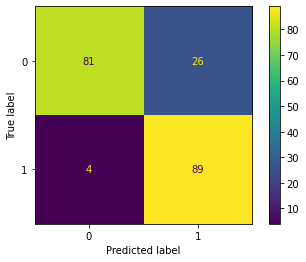

In [16]:
# Como a quantidade de dados de treino não é tão grande, podemos testar vetor de máquina
# de vetores de suporte. Apesar de não apresentar performance melhor que Naive Bayes nas métricas
# a quantidade de falsos negativos reduziu, o que pode ser vantajoso dependendo 
# do valor esperado que poderia ser gerado a partir de cada erro
# Os parâmetros foram retirados de testes feitos com a região de boa acurácia 
# Encontrado no link https://scikit-learn.org/stable/auto_examples/svm/plot_rbf_parameters.html

df_train_classlabel = concat_resampled_training_df[["classlabel"]]
df_train_corr = concat_resampled_training_df[["v70", "v84", "v24", "v44", "v50"]]

real_classlabel_validation = validation_df[["classlabel"]]
data_validation_without_classlabel = validation_df[["v70", "v84", "v24", "v44", "v50"]]

clf = SVC(gamma=0.001, C=100)
clf.fit(df_train_corr, df_train_classlabel)
predicted_classlabel = clf.predict(data_validation_without_classlabel)

accuracy = accuracy_score(real_classlabel_validation, predicted_classlabel)
balanced_accuracy = balanced_accuracy_score(real_classlabel_validation, predicted_classlabel)
f1_score_metric = f1_score(real_classlabel_validation, predicted_classlabel)
confusion_matrix_metric = confusion_matrix(real_classlabel_validation, predicted_classlabel)

metrics_results["svc_five_features"] = {"accuracy": accuracy, \
    "balanced_accuracy": balanced_accuracy, "f1_score_metric": f1_score_metric}

print( "Acurácia - " + str(accuracy))
print( "Acurácia balanceada - " + str(balanced_accuracy))
print( "F1 Score - " + str(f1_score_metric))
ConfusionMatrixDisplay(confusion_matrix=confusion_matrix_metric).plot()



Acurácia - 0.84
Acurácia balanceada - 0.8356949050346698
F1 Score - 0.8181818181818182


/Users/atila/.pyenv/versions/3.7.9/lib/python3.7/site-packages/sklearn/neighbors/_classification.py:179: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


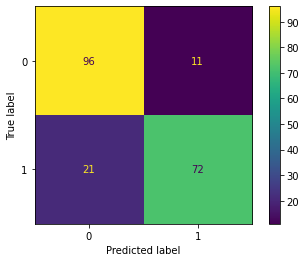

In [17]:
# Alguns parâmetros foram testados para o knn, onde foi percebido que 3 vizinhos se comportam 
# melhor com 4 features ao invés de 5. Com as 5 features, o número de 7 vizinhos foi melhor

df_train_classlabel = concat_resampled_training_df[["classlabel"]]
df_train_corr = concat_resampled_training_df[["v70", "v84", "v24", "v44"]]

real_classlabel_validation = validation_df[["classlabel"]]
data_validation_without_classlabel = validation_df[["v70", "v84", "v24", "v44"]]

neigh = KNeighborsClassifier(n_neighbors=3)
neigh.fit(df_train_corr, df_train_classlabel)

predicted_classlabel = neigh.predict(data_validation_without_classlabel)

accuracy = accuracy_score(real_classlabel_validation, predicted_classlabel)
balanced_accuracy = balanced_accuracy_score(real_classlabel_validation, predicted_classlabel)
f1_score_metric = f1_score(real_classlabel_validation, predicted_classlabel)
confusion_matrix_metric = confusion_matrix(real_classlabel_validation, predicted_classlabel)

metrics_results["knn_four_features"] = {"accuracy": accuracy, \
    "balanced_accuracy": balanced_accuracy, "f1_score_metric": f1_score_metric}

print( "Acurácia - " + str(accuracy))
print( "Acurácia balanceada - " + str(balanced_accuracy))
print( "F1 Score - " + str(f1_score_metric))
ConfusionMatrixDisplay(confusion_matrix=confusion_matrix_metric).plot()


/Users/atila/.pyenv/versions/3.7.9/lib/python3.7/site-packages/ipykernel_launcher.py:8: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


Acurácia - 0.85
Acurácia balanceada - 0.8555924027735906
F1 Score - 0.8529411764705881


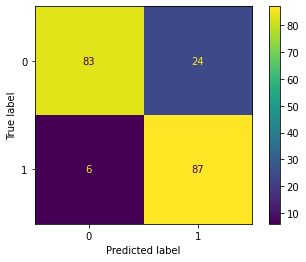

In [18]:
df_train_classlabel = concat_resampled_training_df[["classlabel"]]
df_train_corr = concat_resampled_training_df[["v70", "v84", "v24", "v44", "v50"]]

real_classlabel_validation = validation_df[["classlabel"]]
data_validation_without_classlabel = validation_df[["v70", "v84", "v24", "v44", "v50"]]

clf = RandomForestClassifier(max_depth=4, random_state=0)
clf.fit(df_train_corr, df_train_classlabel)

predicted_classlabel = clf.predict(data_validation_without_classlabel)

accuracy = accuracy_score(real_classlabel_validation, predicted_classlabel)
balanced_accuracy = balanced_accuracy_score(real_classlabel_validation, predicted_classlabel)
f1_score_metric = f1_score(real_classlabel_validation, predicted_classlabel)
confusion_matrix_metric = confusion_matrix(real_classlabel_validation, predicted_classlabel)

metrics_results["random_forest_five_features"] = {"accuracy": accuracy, \
    "balanced_accuracy": balanced_accuracy, "f1_score_metric": f1_score_metric}

print( "Acurácia - " + str(accuracy))
print( "Acurácia balanceada - " + str(balanced_accuracy))
print( "F1 Score - " + str(f1_score_metric))
ConfusionMatrixDisplay(confusion_matrix=confusion_matrix_metric).plot()

/Users/atila/.pyenv/versions/3.7.9/lib/python3.7/site-packages/ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if __name__ == '__main__':


Acurácia - 0.88
Acurácia balanceada - 0.8822228921716411
F1 Score - 0.8762886597938144


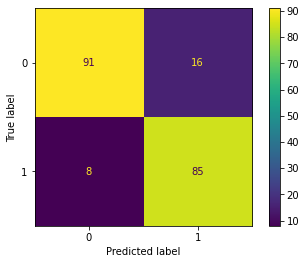

In [19]:
df_train_classlabel = concat_resampled_training_df[["classlabel"]]
df_train_corr = concat_resampled_training_df[["v70", "v84", "v24", "v44", "v50", "v53"]]

real_classlabel_validation = validation_df[["classlabel"]]
data_validation_without_classlabel = validation_df[["v70", "v84", "v24", "v44", "v50", "v53"]]

clf = RandomForestClassifier(max_depth=4, random_state=0)

clf.fit(df_train_corr, df_train_classlabel)

predicted_classlabel = clf.predict(data_validation_without_classlabel)

accuracy = accuracy_score(real_classlabel_validation, predicted_classlabel)
balanced_accuracy = balanced_accuracy_score(real_classlabel_validation, predicted_classlabel)
f1_score_metric = f1_score(real_classlabel_validation, predicted_classlabel)
confusion_matrix_metric = confusion_matrix(real_classlabel_validation, predicted_classlabel)

metrics_results["random_forest_six_features"] = {"accuracy": accuracy, \
    "balanced_accuracy": balanced_accuracy, "f1_score_metric": f1_score_metric}

print( "Acurácia - " + str(accuracy))
print( "Acurácia balanceada - " + str(balanced_accuracy))
print( "F1 Score - " + str(f1_score_metric))
ConfusionMatrixDisplay(confusion_matrix=confusion_matrix_metric).plot()

/Users/atila/.pyenv/versions/3.7.9/lib/python3.7/site-packages/ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if __name__ == '__main__':


Acurácia - 0.875
Acurácia balanceada - 0.8768465480856196
F1 Score - 0.8704663212435233


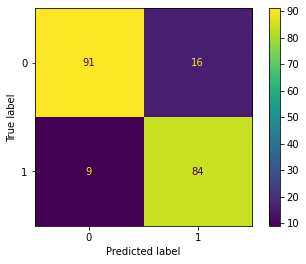

In [20]:
df_train_classlabel = concat_resampled_training_df[["classlabel"]]
df_train_corr = concat_resampled_training_df[["v70", "v84", "v24", "v44", "v50", "v53"]]

real_classlabel_validation = validation_df[["classlabel"]]
data_validation_without_classlabel = validation_df[["v70", "v84", "v24", "v44", "v50", "v53"]]

clf = RandomForestClassifier(max_depth=4, random_state=0, n_estimators=400)

clf.fit(df_train_corr, df_train_classlabel)

predicted_classlabel = clf.predict(data_validation_without_classlabel)

accuracy = accuracy_score(real_classlabel_validation, predicted_classlabel)
balanced_accuracy = balanced_accuracy_score(real_classlabel_validation, predicted_classlabel)
f1_score_metric = f1_score(real_classlabel_validation, predicted_classlabel)
confusion_matrix_metric = confusion_matrix(real_classlabel_validation, predicted_classlabel)

metrics_results["random_forest_six_features_with_tune_of_trees"] = {"accuracy": accuracy, \
    "balanced_accuracy": balanced_accuracy, "f1_score_metric": f1_score_metric}

print( "Acurácia - " + str(accuracy))
print( "Acurácia balanceada - " + str(balanced_accuracy))
print( "F1 Score - " + str(f1_score_metric))
ConfusionMatrixDisplay(confusion_matrix=confusion_matrix_metric).plot()

/Users/atila/.pyenv/versions/3.7.9/lib/python3.7/site-packages/ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if __name__ == '__main__':


Acurácia - 0.885
Acurácia balanceada - 0.8861923424781428
F1 Score - 0.8795811518324608


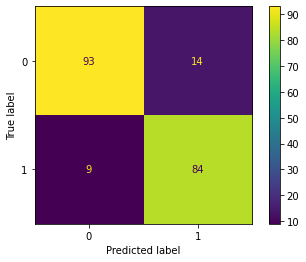

In [21]:
df_train_classlabel = concat_resampled_training_df[["classlabel"]]
df_train_corr = concat_resampled_training_df.drop(columns=['classlabel', 'v68', 'v95'])

real_classlabel_validation = validation_df[["classlabel"]]
data_validation_without_classlabel = validation_df.drop(columns=['classlabel', 'v68', 'v95'])

clf = RandomForestClassifier(max_depth=4, random_state=0, n_estimators=400)

clf.fit(df_train_corr, df_train_classlabel)

importances = {}
for name, importance in zip(data_validation_without_classlabel.columns, clf.feature_importances_):
     importances[name] = importance

predicted_classlabel = clf.predict(data_validation_without_classlabel)

accuracy = accuracy_score(real_classlabel_validation, predicted_classlabel)
balanced_accuracy = balanced_accuracy_score(real_classlabel_validation, predicted_classlabel)
f1_score_metric = f1_score(real_classlabel_validation, predicted_classlabel)
confusion_matrix_metric = confusion_matrix(real_classlabel_validation, predicted_classlabel)

metrics_results["random_forest_all_valid_features_with_tune_of_trees"] = {"accuracy": accuracy, \
    "balanced_accuracy": balanced_accuracy, "f1_score_metric": f1_score_metric}

print( "Acurácia - " + str(accuracy))
print( "Acurácia balanceada - " + str(balanced_accuracy))
print( "F1 Score - " + str(f1_score_metric))
ConfusionMatrixDisplay(confusion_matrix=confusion_matrix_metric).plot()

In [22]:
# Levando em conta as metodologias de classificação, poderíamos sugerir utilizar 
# random forest ou máquina de vetores de suporte para a resolução do problema.

# A escolha de qual modelo pode variar pelo custo ou retorno financeiro 
# que cada erro/acerto gera no problema de negócio.

# A diferença de performances pode ser alterada devido a etapa de balanceamento
# da base de treinamento, foi se escolhida remover dados ao invés de duplicar 
# dados que tinham "desvantagem"

pd.DataFrame.from_records(metrics_results).transpose().sort_values("f1_score_metric", ascending=False)


,accuracy,balanced_accuracy,f1_score_metric
random_forest_all_valid_features_with_tune_of_trees,0.885,0.886192,0.879581
random_forest_six_features,0.880,0.882223,0.876289
random_forest_six_features_with_tune_of_trees,0.875,0.876847,0.870466
svc_five_features,0.850,0.856999,0.855769
random_forest_five_features,0.850,0.855592,0.852941
naive_bayes_five_features,0.850,0.853482,0.848485
decision_tree_six_features,0.820,0.823334,0.818182
knn_four_features,0.840,0.835695,0.818182
decision_tree_except_v68,0.800,0.807457,0.809524
naive_bayes_six_features,0.795,0.788011,0.757396


In [23]:
# Diferente do que foi proposto, os melhores resultados da random forest vieram
# da utilização da feature v53 ao invés da feature v70, chegando a 0.90 no F1 Score

# Porém ao testar os outros algoritmos sem a feature v70, os resultados não 
# Se comportaram tão performáticos quanto o da random forest


features_importances = pd.DataFrame.from_dict(importances, 
    orient="index").reset_index().rename(columns={"index": "Feature", 0: "Importance"})
features_importances.sort_values("Importance", ascending=False)


,Feature,Importance
8,v24,0.179629
17,v84,0.169056
3,v50,0.130823
18,v44,0.110167
14,v53,0.094574
5,v70,0.078487
12,v99,0.047277
7,v20,0.033666
13,v42,0.026536
6,v55,0.023612
